# UNIVERSIDAD TECNOLÓGICA NACIONAL

# Facultad Regional Buenos Aires

## Teoría de los Circuitos II

## Año 2022

### Trabajo Semanal Nº9

### Profesor: Mariano Llamedo Soria 

### Ayudante: Eugenia Ipar

### Giuliana Ruffa (Legajo: 1774463) 

###### Parte 1: Diseño de filtros

Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño:

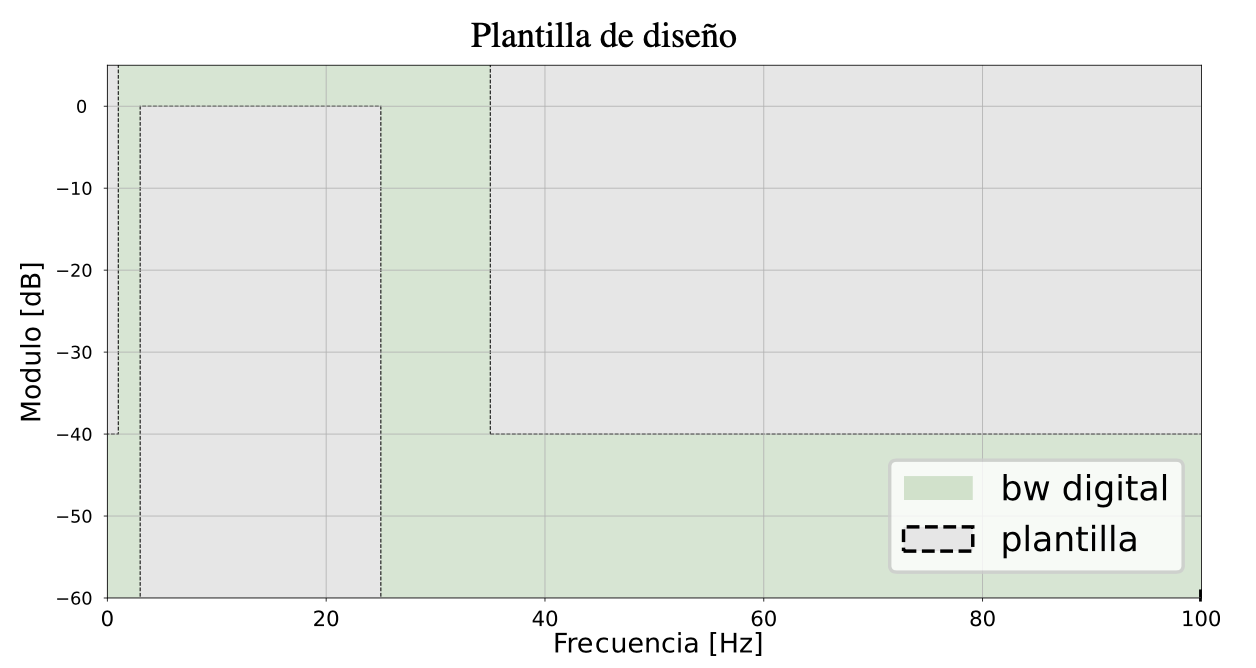

y se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados. Mostrar la respuesta en frecuencia, para ambos filtros, de:

a) módulo, 

b) fase 

c) retardo 

d) y respuesta al impulso.

###### Resolución: IIR

Resolvemos a partir del diseño con Python.

A partir de la plantilla, observamos que fs= 25Hz, fp= 35Hz, $\alpha _{max}$ =0 y $\alpha _{min}$ =40dB .

###### Python

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from splane import plot_plantilla
from pylab import *

def impz(b,a,c,d):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = sig.lfilter(b,a,impulse)
    subplot(211)
    stem(x, response)
    xlim([c,d])
    ylabel('Amplitude')
    xlabel(r'n (samples)')
    title(r'Impulse response')


fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla

# filter design
ripple = 0 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

Ahora, calculamos utilizando la función iirdesing:

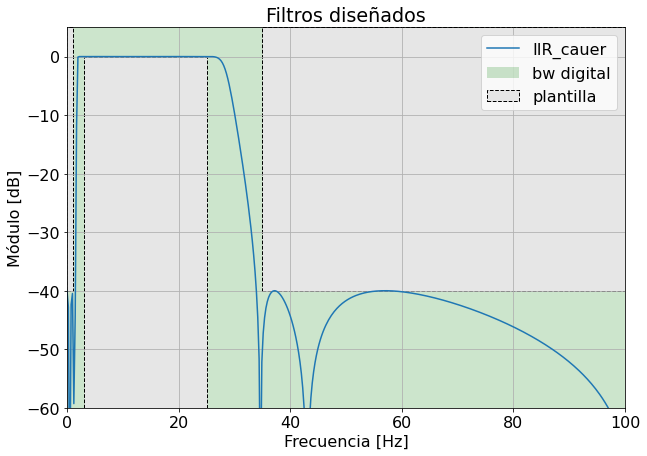

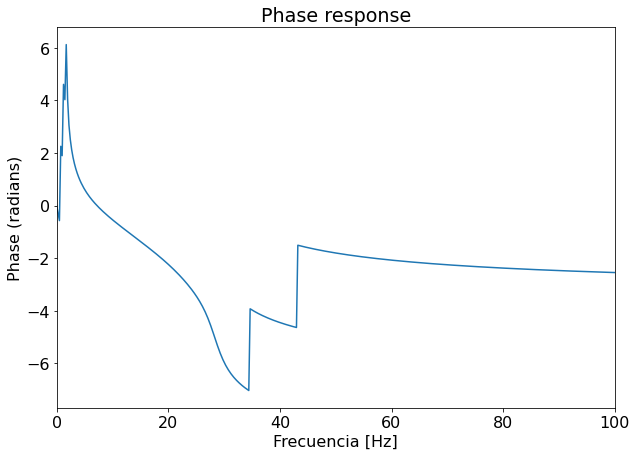

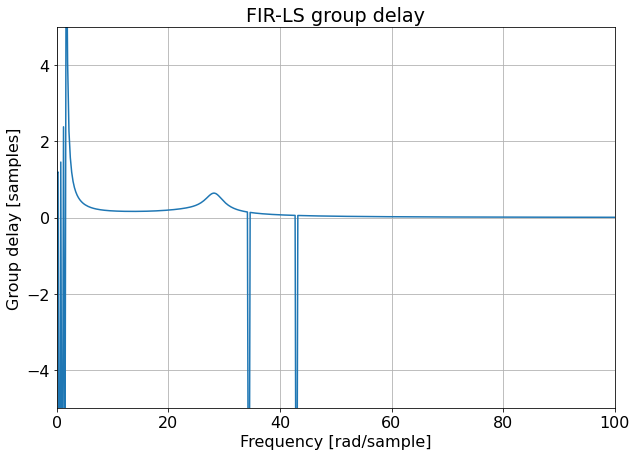

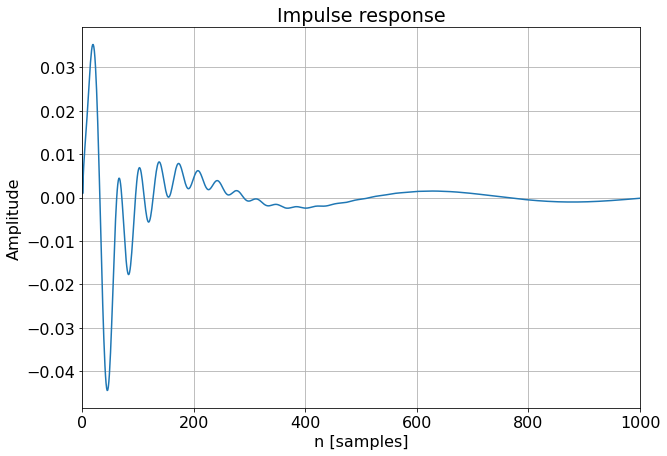

In [2]:
# Design IIR CAUER

iir_sos_cauer = sig.iirdesign(wp=np.array([wp1-1, wp2+1]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.01, gstop=40., analog=False, ftype='ellip', output='sos')

w_cauer,h=sig.sosfreqz(iir_sos_cauer, worN=2048)
a,b=sig.sos2tf(iir_sos_cauer)
# renormalizo el eje de frecuencia
w_cauer = w_cauer / np.pi * nyq_frec

plt.plot(w_cauer, 20 * np.log10(abs(h)), label='IIR_cauer')

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.figure(2)
h_Phase = np.unwrap(arctan2(imag(h),real(h)))
plt.plot(w_cauer,h_Phase)
plt.ylabel('Phase (radians)')
plt.xlabel('Frecuencia [Hz]')
plt.title(r'Phase response')
plt.xlim([0,100])

plt.figure(3)
gd = -np.diff(h_Phase) / np.diff(w_cauer)
plt.title('FIR-LS group delay')
n = np.arange(len(gd))
plt.plot(w_cauer[:-1], gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.xlim([0,100])
plt.ylim([-5,5])
plt.show()


plt.figure(4)
l = len(h)
impulse = repeat(0.,l); impulse[0] =1.
x = arange(0,l)
response = sig.sosfilt(iir_sos_cauer, impulse)
plt.plot(x, response)
plt.ylabel('Amplitude')
plt.xlabel('n [samples]')
plt.title('Impulse response')
plt.grid()
plt.xlim([0,1000])
plt.show()

###### Resolución: FIR

Resolvemos a partir del diseño con Python. Se cambia la cantidad de coeficientes a 2871 para obtener una respuesta al impulso correcta.

Calculamos utilizando la función sig.firls:

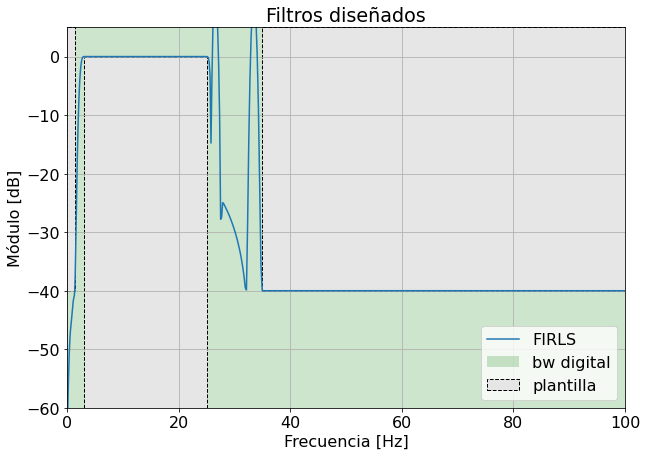

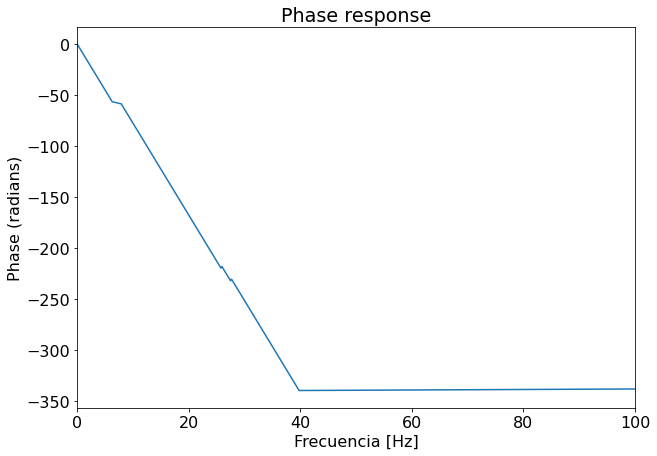

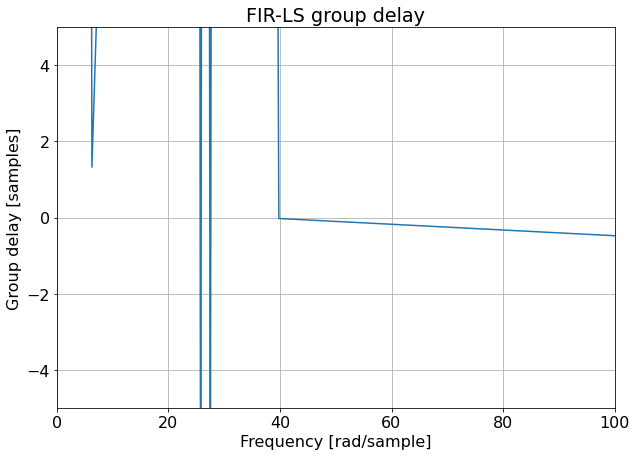

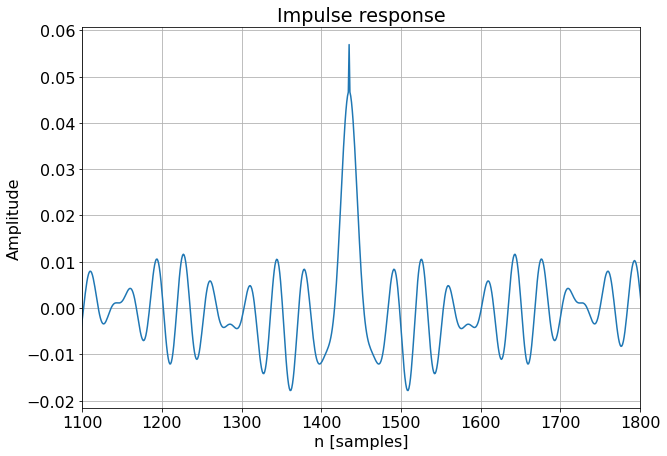

In [3]:
# Design FIR

import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from splane import plot_plantilla
import splane as sp
from pylab import *

fs = 1000 # Hz
nyq_frec = fs / 2

numtaps = 1501

frecs_ls = np.array([0.0,      ws1+.4,         wp1,     wp2,  28, 32,   ws2,         nyq_frec   ])  / nyq_frec
gains_ls = np.array([-atenuacion*2, -atenuacion, -ripple, -ripple,-25,-40, -atenuacion, -atenuacion])
gains_ls = 10**(gains_ls/20)  

cant_coeficientes = 2871

num_firls = sig.firls(cant_coeficientes, frecs_ls, gains_ls)

den = 1 
# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_firls, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIRLS')

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs_ls[ [1, 6] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.figure(2)
h_Phase = np.unwrap(arctan2(imag(hh_win),real(hh_win)))
plt.plot(w,h_Phase)
plt.ylabel('Phase (radians)')
plt.xlabel('Frecuencia [Hz]')
plt.title(r'Phase response')
plt.xlim([0,100])

plt.figure(3)
gd = -np.diff(h_Phase) / np.diff(w)
plt.title('FIR-LS group delay')
n = np.arange(len(gd))
plt.plot(w[:-1], gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.xlim([0,100])
plt.ylim([-5,5])
plt.show()


plt.figure(4)
l = len(num_firls)
impulse = repeat(0.,l); impulse[0] =1.
x = arange(0,l)
response = sig.lfilter(num_firls, den, impulse)
plt.plot(x, response)
plt.ylabel('Amplitude')
plt.xlabel('n [samples]')
plt.title('Impulse response')
plt.grid()
plt.xlim([1100,1800])
plt.show()

Y ahora, calculamos utilizando firwin2:

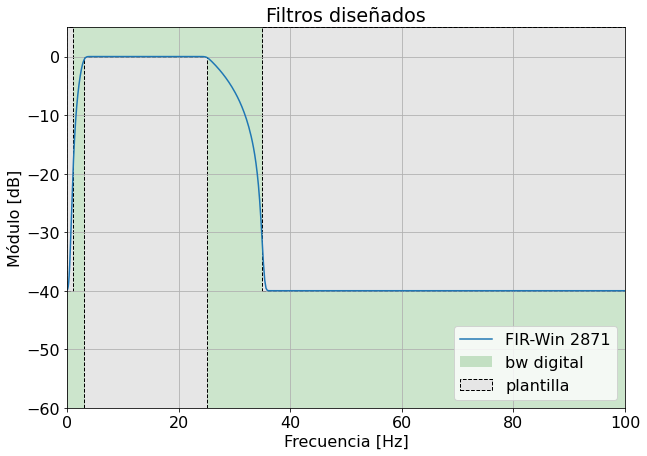

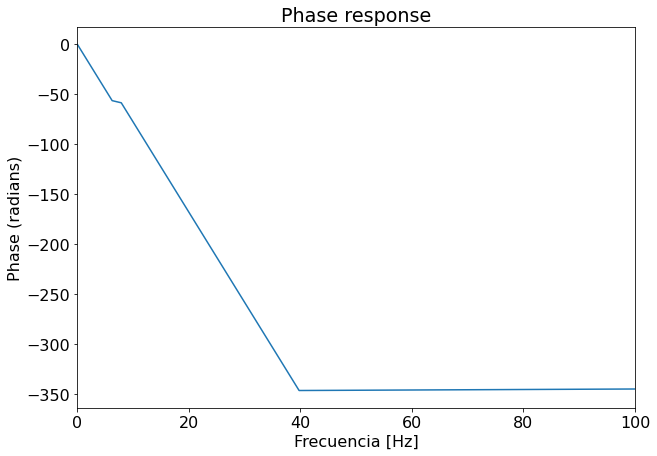

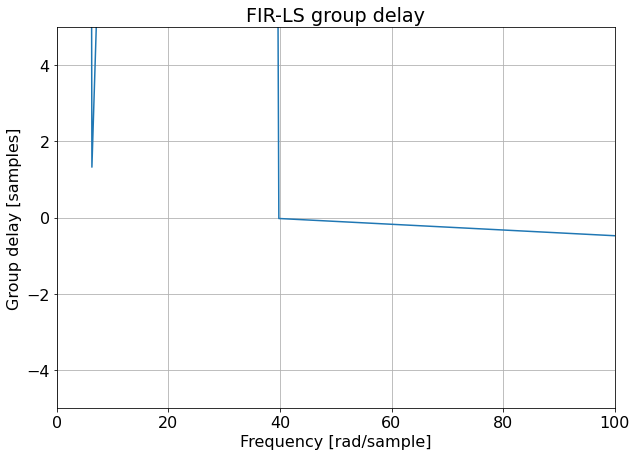

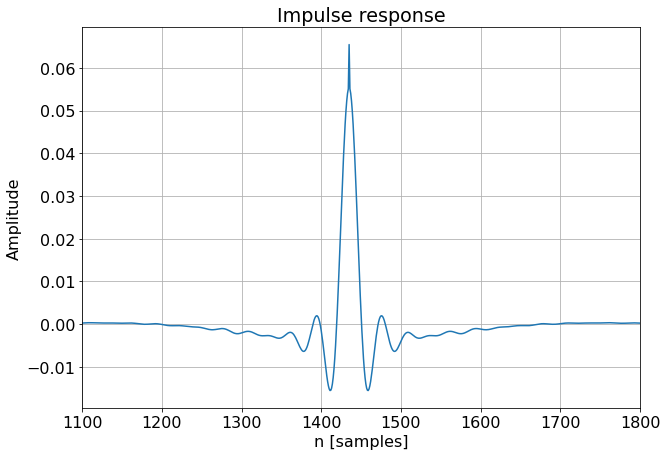

In [4]:
  
cant_coeficientes = 2871

num_win = sig.firwin2(cant_coeficientes, frecs, gains , window='blackmanharris' )

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))

plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion, fs = fs)

plt.figure(2)
h_Phase = np.unwrap(arctan2(imag(hh_win),real(hh_win)))
plt.plot(w,h_Phase)
plt.ylabel('Phase (radians)')
plt.xlabel('Frecuencia [Hz]')
plt.title(r'Phase response')
plt.xlim([0,100])

plt.figure(3)
gd = -np.diff(h_Phase) / np.diff(w)
plt.title('FIR-LS group delay')
n = np.arange(len(gd))
plt.plot(w[:-1], gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.xlim([0,100])
plt.ylim([-5,5])
plt.show()


plt.figure(4)
l = len(num_win)
impulse = repeat(0.,l); impulse[0] =1.
x = arange(0,l)
response = sig.lfilter(num_win, den, impulse)
plt.plot(x, response)
plt.ylabel('Amplitude')
plt.xlabel('n [samples]')
plt.title('Impulse response')
plt.grid()
plt.xlim([1100,1800])
plt.show()

Observamos que las respuestas son similares, por lo tanto, se verifica.

###### Parte 2: Implementación y Uso

###### IIR y FIR

In [5]:
# IIR
ECG_f_butt = sig.sosfiltfilt(iir_sos_cauer, ecg_one_lead)

# FIR
ECG_f_win = sig.lfilter(num_win, den, ecg_one_lead)

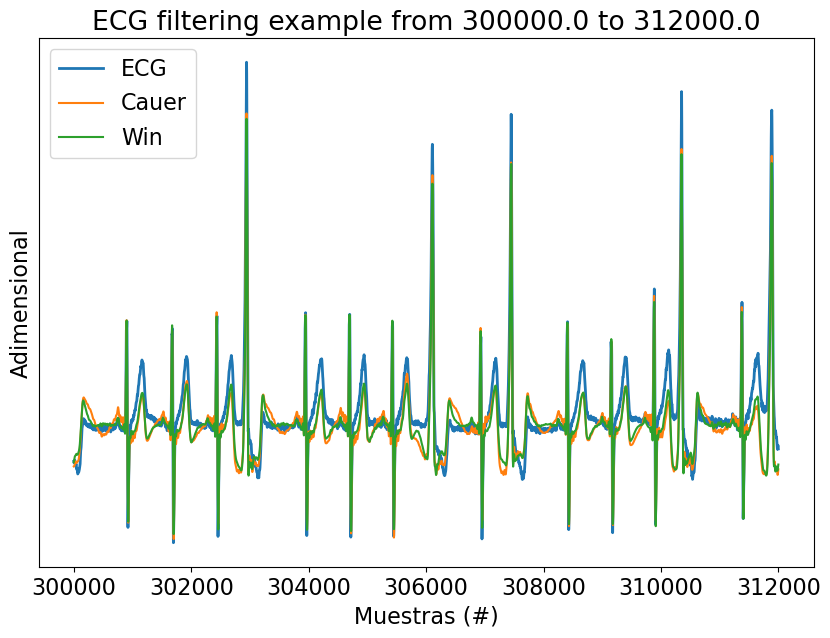

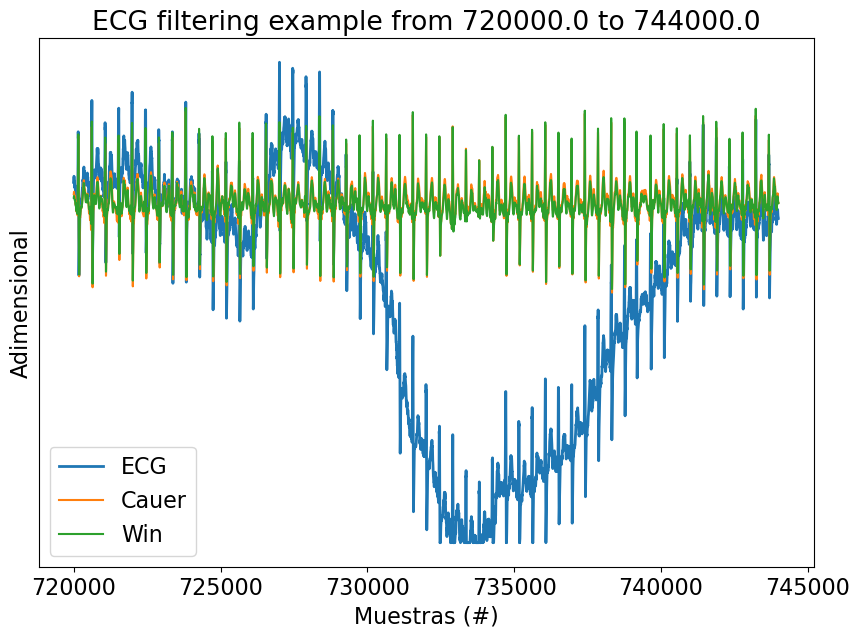

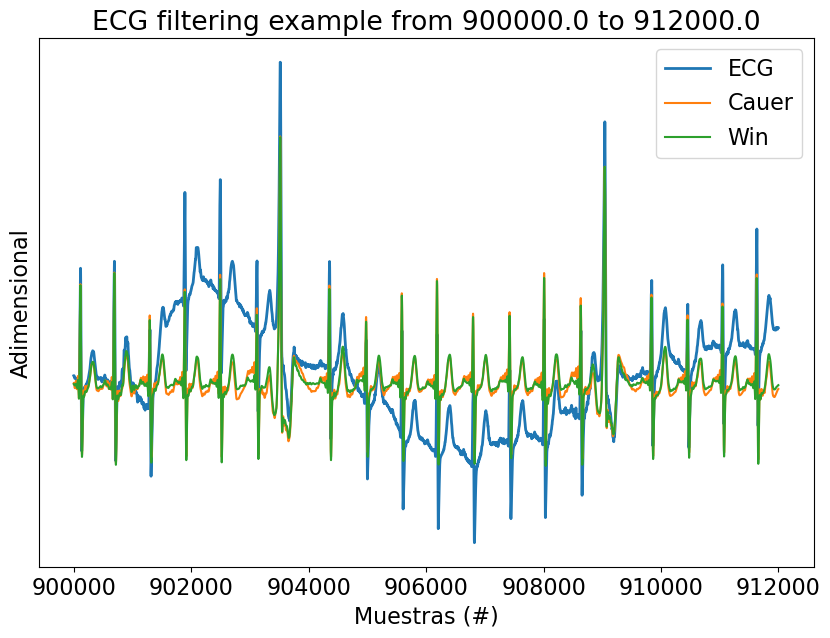

In [6]:
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 1435


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Cauer')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

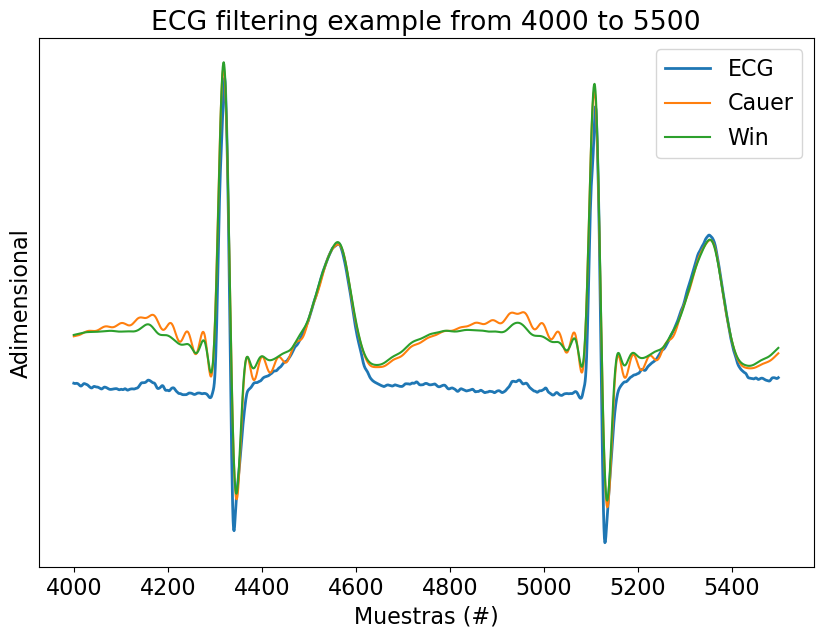

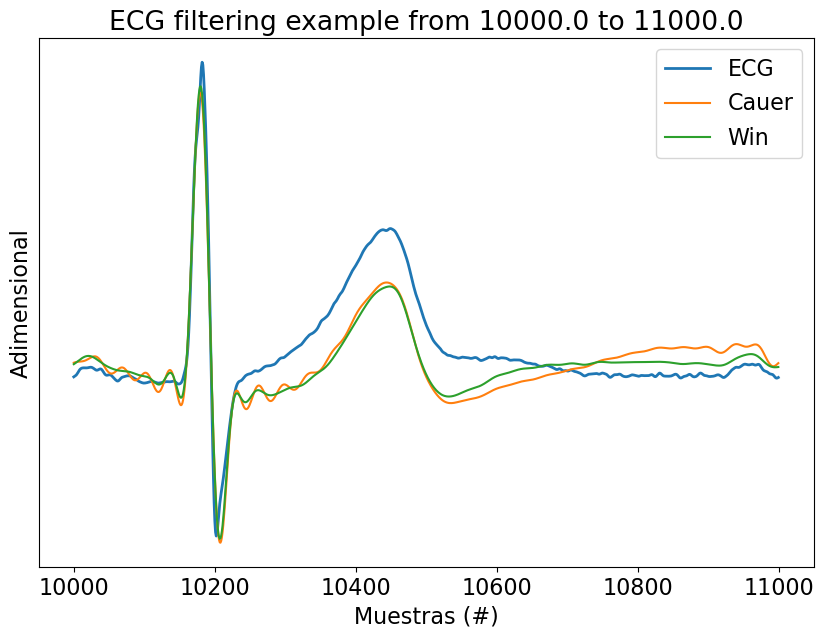

In [7]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Cauer')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

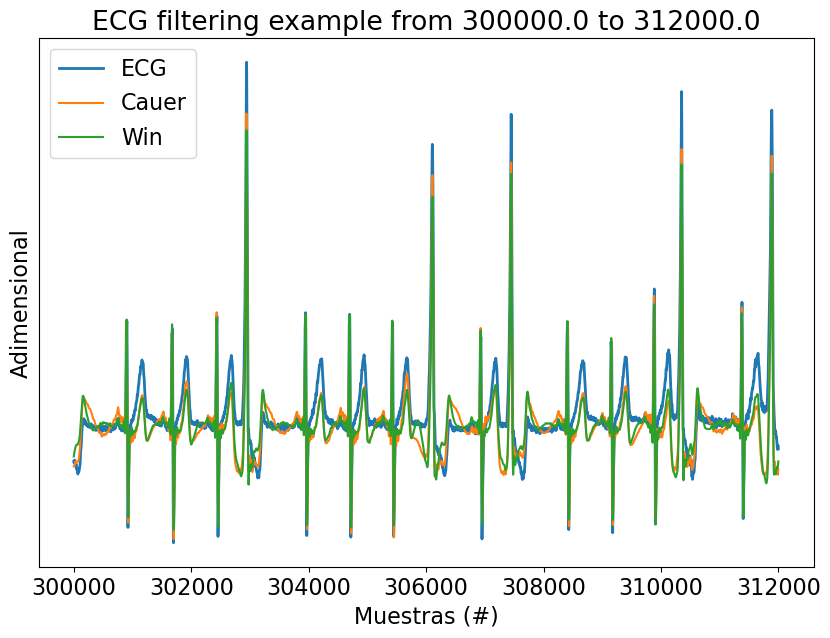

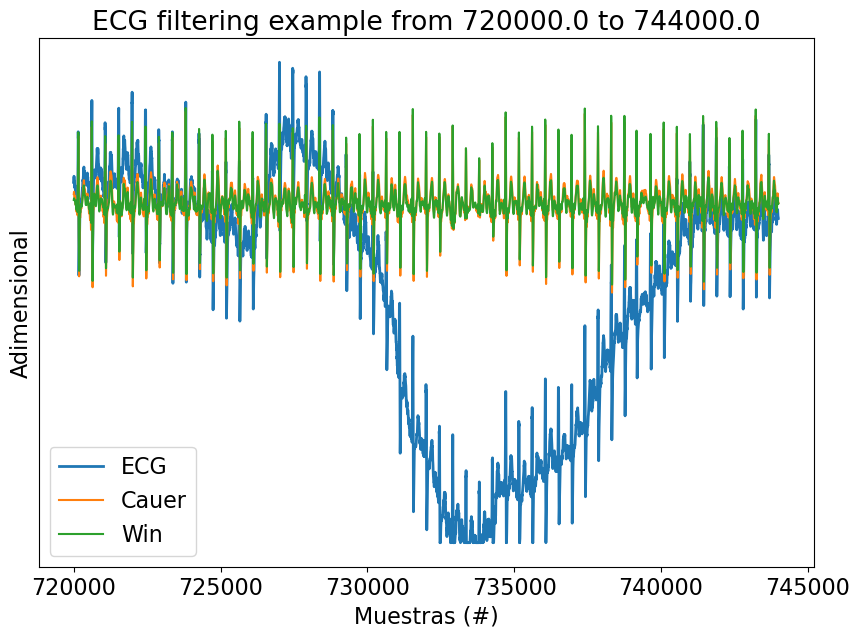

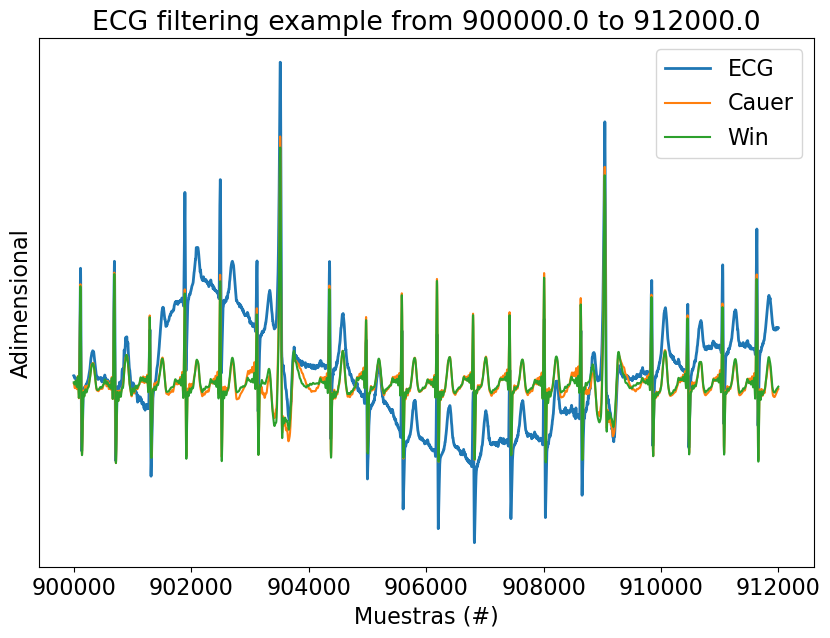

In [8]:
# Procedemos al filtrado
# ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)

ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Cauer')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

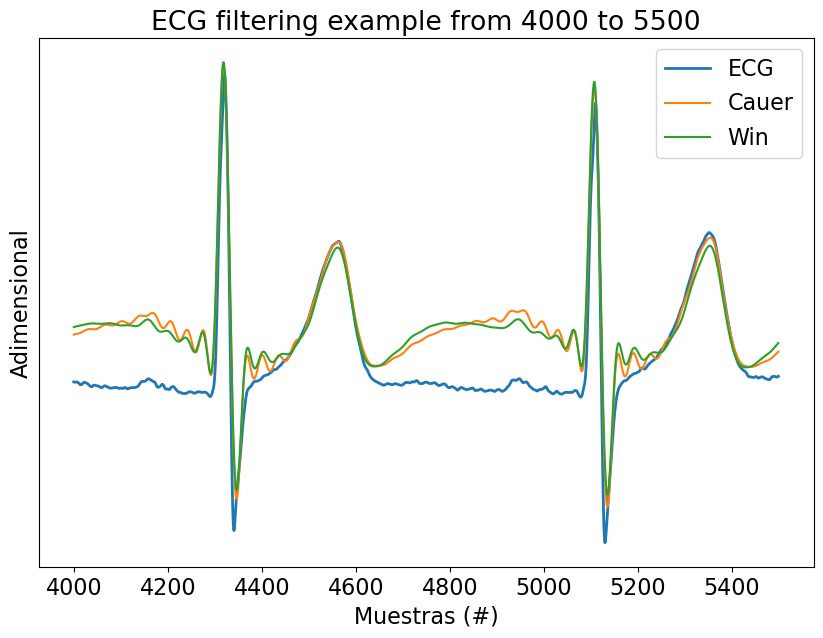

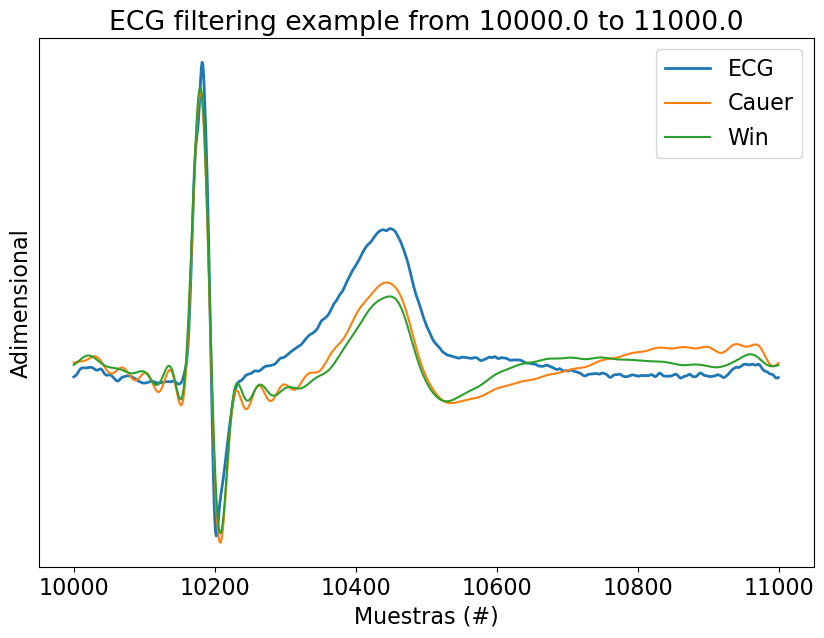

In [9]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Cauer')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()